# Uvod #

U ovoj vježbi naučit ćete kako poboljšati rezultate treninga uključivanjem povratnog poziva ranog zaustavljanja kako biste spriječili prekomjerno opremanje.

Kada budete spremni, pokrenite ovu sljedeću ćeliju da sve postavite!

In [1]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')



Prvo učitajte skup podataka *Spotify*. Vaš će zadatak biti predvidjeti popularnost pjesme na temelju različitih audio značajki, kao što su `'tempo'`, `'danceability'` i `'mode'`.

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

spotify = pd.read_csv('./input/spotify.csv')

X = spotify.copy().dropna()
y = X.pop('track_popularity')
artists = X['track_artist']

features_num = ['danceability', 'energy', 'key', 'loudness', 'mode',
                'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms']
features_cat = ['playlist_genre']

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),
    (OneHotEncoder(), features_cat),
)

# We'll do a "grouped" split to keep all of an artist's songs in one
# split or the other. This is to help prevent signal leakage.
def group_split(X, y, group, train_size=0.75):
    splitter = GroupShuffleSplit(train_size=train_size)
    train, test = next(splitter.split(X, y, groups=group))
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

X_train, X_valid, y_train, y_valid = group_split(X, y, artists)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
y_train = y_train / 100 # popularity is on a scale 0-100, so this rescales to 0-1.
y_valid = y_valid / 100

input_shape = [X_train.shape[1]]
print("Input shape: {}".format(input_shape))


Input shape: [18]


Počnimo s najjednostavnijom mrežom, linearnim modelom. Ovaj model ima mali kapacitet.

Pokrenite ovu sljedeću ćeliju bez ikakvih promjena za obuku linearnog modela na *Spotify* skupu podataka.




Minimum Validation Loss: 0.1897


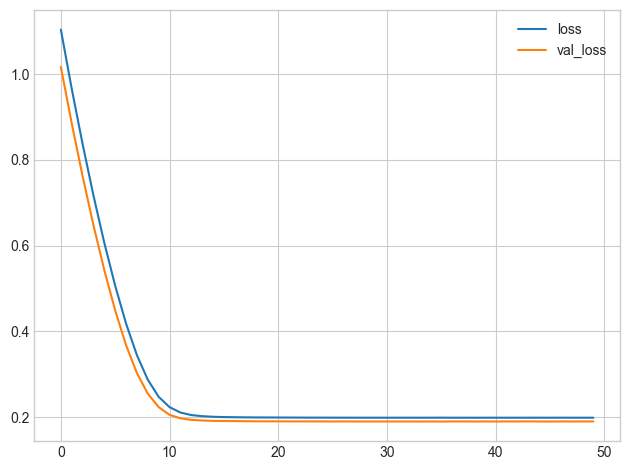

In [3]:
model = keras.Sequential([
    layers.Dense(1, input_shape=input_shape),
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    verbose=0, # suppress output since we'll plot the curves
)
history_df = pd.DataFrame(history.history)
history_df.loc[0:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Nije neuobičajeno da krivulje slijede uzorak "hokejaške palice" kao što vidite ovdje. Zbog toga je završni dio treninga teško vidljiv, pa umjesto toga počnimo od epohe 10:

Minimum Validation Loss: 0.1897


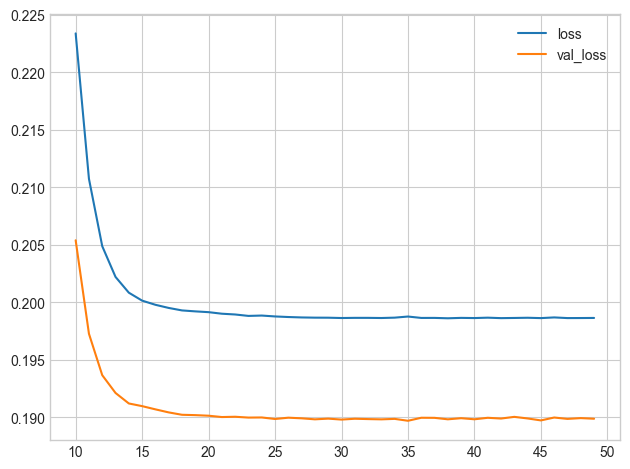

In [4]:
# Start the plot at epoch 10
history_df.loc[10:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 1) Procijenite osnovnu liniju

Što misliš? Biste li rekli da je ovaj model underfitting, overfitting, ili baš kako treba?

Sada dodajmo malo kapaciteta našoj mreži. Dodat ćemo tri skrivena sloja sa po 128 jedinica. Pokrenite sljedeću ćeliju da uvježbate mrežu i vidite krivulje učenja.

Epoch 1/50
49/49 [==============================] - 1s 3ms/step - loss: 0.2278 - val_loss: 0.1985
Epoch 2/50
49/49 [==============================] - 0s 2ms/step - loss: 0.2027 - val_loss: 0.1935
Epoch 3/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1979 - val_loss: 0.1913
Epoch 4/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1949 - val_loss: 0.1911
Epoch 5/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1923 - val_loss: 0.1908
Epoch 6/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1909 - val_loss: 0.1909
Epoch 7/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1893 - val_loss: 0.1913
Epoch 8/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1887 - val_loss: 0.1922
Epoch 9/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1875 - val_loss: 0.1909
Epoch 10/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1866 - val_loss: 0.1910
Epoch 11/50
49/49 [

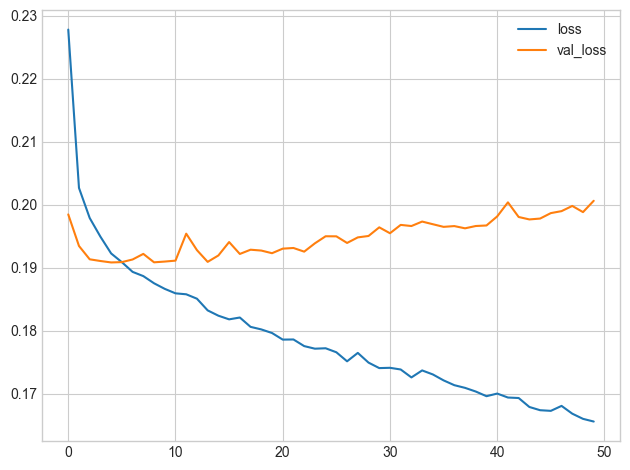

In [5]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu', input_shape=input_shape),
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 2) Dodajte kapacitet

Kakva je vaša ocjena ovih krivulja? underfitting, overfitting, baš kako treba?

# 3) Definirajte rano zaustavljanje povratnog poziva

Sada definirajte povratni poziv ranog zaustavljanja koji čeka 5 epoha (`patience`) za promjenu u gubitku valjanosti od najmanje `0,001` (`min_delta`) i zadržava težine s najboljim gubitkom (`restore_best_weights`).

In [7]:
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping

# YOUR CODE HERE: define an early stopping callback
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True
)


Sada pokrenite ovu ćeliju da uvježbate model i dobijete krivulje učenja. Obratite pažnju na argument `callbacks` u `model.fit`.

Epoch 1/50
49/49 [==============================] - 1s 4ms/step - loss: 0.2354 - val_loss: 0.1992
Epoch 2/50
49/49 [==============================] - 0s 2ms/step - loss: 0.2023 - val_loss: 0.1956
Epoch 3/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1970 - val_loss: 0.1950
Epoch 4/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1944 - val_loss: 0.1919
Epoch 5/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1917 - val_loss: 0.1936
Epoch 6/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1905 - val_loss: 0.1910
Epoch 7/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1892 - val_loss: 0.1918
Epoch 8/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1877 - val_loss: 0.1921
Epoch 9/50
49/49 [==============================] - 0s 2ms/step - loss: 0.1871 - val_loss: 0.1920
Minimum Validation Loss: 0.1910


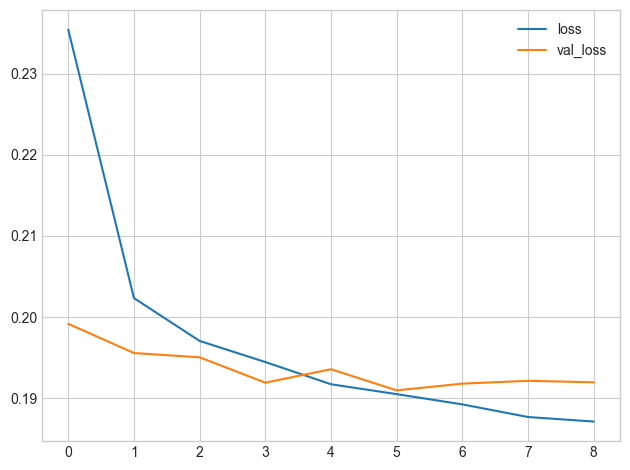

In [8]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=input_shape),
    layers.Dense(64, activation='relu'),    
    layers.Dense(1)
])
model.compile(
    optimizer='adam',
    loss='mae',
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=50,
    callbacks=[early_stopping]
)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

# 4) Uvježbavanje i tumačenje

Je li to bilo poboljšanje u usporedbi s treningom bez ranog prekida?

Ako želite, pokušajte eksperimentirati s `patience` i `min_delta` da vidite kakvu bi razliku moglo napraviti.

# Nastavi #

Prijeđite na [**sljedeću vježbu**](Dropout_and_Batch_Normalization_hr.ipynb): batch normalization i dropout.